In [1]:
import numpy as np
import pandas as pd
import re
import scipy.stats as st
import sklearn.metrics as met
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
import time
import copy

%matplotlib inline
title = 'PPD'
path = '../sources/data/PPD-First-Round-Data'
icy = 'target'

# PPD

## Reload Data
Load data from database, then concatenate and summerize data

In [2]:
pathofDataSaving = '../sources/deal/PPD-Data-Saving'
da = pd.read_hdf('{}/{}_da.h5'.format(pathofDataSaving, title), key = 'da')
dah1 = pd.read_hdf('{}/{}_dah1.h5'.format(pathofDataSaving, title), key = 'dah')
dah2 = pd.read_hdf('{}/{}_dah2.h5'.format(pathofDataSaving, title), key = 'dah')
irt = np.load('{}/{}_irt.npy'.format(pathofDataSaving, title))
irv = np.load('{}/{}_irv.npy'.format(pathofDataSaving, title))
print da.shape
# print dah1.shape
# print dah2.shape

(49999, 227)
(966431, 2)
(621295, 1)


### Preprocessing & Concatenate Historical Data with Master Data

In [4]:
def Preprocess_historicalData(dah, iccat, name, da):
    grp1 = dah.reset_index()[["Id", "Time"]].groupby("Id")
    grp2 = dah.groupby(level = ["Id", "Time"]).first().reset_index()[["Id", "Time"]].groupby("Id")
    dahc1 = pd.concat([grp1.first(), grp1.count()], axis = 1, ignore_index = True).rename(columns = {0:"FirstTime", 1:"Count"})
    dahc1 = dahc1.assign(DayFreq = grp2.count()["Time"]/(1-dahc1["FirstTime"])).loc[da.index]
    dahc2 = dah.reset_index().groupby(["Id"]+iccat).count().unstack(iccat)["Time"].loc[da.index]
    dahc = pd.concat([dahc1, pd.DataFrame({"Cats": dahc2.notnull().sum(axis = 1)}), dahc2], axis = 1).fillna(0)
    dahc.columns = ["{}_{}".format(name, x) for x in dahc.columns]
    return(dahc)

dah1c = Preprocess_historicalData(dah1, list(dah1.columns), 'Log', da)
dah2c = Preprocess_historicalData(dah2, list(dah2.columns), 'Userupdate', da)
# print dah1c.head()
# print dah2c.head()
da = pd.concat([da, dah1c, dah2c], axis = 1)
da.shape

(49999, 352)

### Summarize Data
Get univariate summary statistics of data:
* Non-NA values for all variables
* The 5 most frequent values for all variables
* Mean, standard error, and quantiles for numeric variables

In [5]:
def Value_counts(das, nhead = 5):
    tmp = pd.value_counts(das).reset_index().rename_axis({'index': das.name}, axis = 1)
    value = pd.DataFrame(['value {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,0], how = 'left').set_index(0).T
    freq = pd.DataFrame(['freq {}'.format(x+1) for x in range(nhead)], index = np.arange(nhead)).join(tmp.iloc[:,1], how = 'left').set_index(0).T
    nnull = das.isnull().sum()
    freqother = pd.DataFrame({das.name: [das.shape[0]-nnull-np.nansum(freq.values), nnull]}, index = ['freq others', 'freq NA']).T
    op = pd.concat([value, freq, freqother], axis = 1)
    return(op)

def Summary(da):
    op = pd.concat([pd.DataFrame({'type': da.dtypes, 'non-NA': da.notnull().sum(axis = 0)}), 
                    da.describe().T.iloc[:,1:], 
                    pd.concat(map(lambda i: Value_counts(da.loc[:,i]), da.columns))], axis = 1).loc[da.columns]
    op.index.name = 'Columns'
    return(op)
# Summary(da)
# Summary(da).to_csv('./PPD-Data-Saving/{}_summary_da.csv'.format(path, title), encoding='utf-8')

## Clean Data

Input Data: 
* da: master data. types: Numeric, Categorical, Time, or a series of similar columns
* daa*: appendix data for da
    * PPD_daa.csv: additional description of data types 原始数据:各字段数据类型说明
    * cnd_da_city_0.csv: China city rank data 外部数据1:中国城市等级
    * cnd_da_city_1.csv: China province/city/county longitudinal/latitudinal data 外部数据2:中国城市经纬度
* ictype: a dict indicating types of and methods for columns of da

Processing:
1. Prepare daa and ictype for transforming da
1. Transforming all of da columns into numeric according to ictype
    * Numeric: Keep
    * Non-numeric: 
        * With additional information: Mapping into numeric
            * Ordinal: As numeric
            * Time: Transform into days and cycles of year, month, week
            * With information in appendix data: Mapping into numeric according to daa*
        * Without additional information: Mapping into 0-1 dummy variables from one-hot encoding, combining or deleting low frequency categories
    * A series of similar columns: Transform the column series into columns of summary statistics, keeping or deleting original columns
    * Count NA numbers in different series of variables
1. Deleting the columns with almost all identical or NA values
1. Deleting the columns with serious collinearity with any column before

Output Data:
* dac: cleaned data. types: numeric


### 加载外部数据并处理

daa —— 字段类型说明  
cnd_da_city_0 —— 城市等级  
cnd_da_city_1 —— 城市所在经纬度  

In [6]:
def Del_string(xstr):
    xstrc = xstr.strip().strip(u'市').strip(u'省')
    if(xstrc == ''):
        xstrc = np.nan
    return(xstrc)

daa = pd.read_csv('{}/{}_daa.csv'.format(path, title), index_col = 'Column')['Type']
daacity0 = pd.read_csv('{}/cnd_da_city_0.csv'.format(path), encoding = 'GB18030', index_col = 0)
daacity1 = pd.read_csv('{}/cnd_da_city_1.csv'.format(path), encoding = 'GB18030',\
                       converters = {'Prov': Del_string, 'City': Del_string, 'District': Del_string})

daacity1= (pd.concat(map(lambda i: daacity1.drop_duplicates([i]).set_index([i]).iloc[:,2:], ["Prov", "City", "District"]))
            .reset_index().drop_duplicates(["index"]).set_index(["index"]))
daacity = daacity1.join(daacity0, how = "left")
daacity.head()

,Longitude,Latitude,LongpLat,LongmLat,CityRank
index,,,,,
北京,116.40,39.90,156.30,76.50,1.0
天津,117.20,39.12,156.32,78.08,1.0
河北,114.52,38.05,152.57,76.47,NaN
山西,112.55,37.87,150.42,74.68,NaN
内蒙古自治区,111.73,40.83,152.56,70.90,NaN


### 设置ictype: 
#### ictype is a dict indicating types of and methods for columns of da, ictype 给出了字段类型&预处理方法
* ['UserInfo_{}'.format(i) for i in [2, 4, 8, 20, 7, 19]] 均与省市相关，单独处理，处理方法即catmapd
* thirdparty相关的字段均为数值化字段,一共119个,观察它们的统计量情况发现，不同period的相同后缀字段统计量相似，因此对它们进行一次汇总处理；备注：按'_'分割后提取013信息,而不是023
* catbin相关字段是需要分箱的字段

In [7]:
def Col_group(ic, i = 0):
    cols = pd.Series([x.split('_')[i] for x in ic], index = ic)
    return(cols)

ictype = {'y': ['target'],
          'date': ['ListingInfo'],
          'catmap': ['UserInfo_{}'.format(i) for i in [2, 4, 8, 20, 7, 19]],
          'catmapd': [daacity]*6,
        }
ictype['cols'] = Col_group(da.drop(ictype['y'], axis = 1).columns)
tmp = ictype['cols'].index[ictype['cols'] == 'ThirdParty']
ictype['serials'] = pd.Series(['_'.join([x.split('_')[i] for i in [0,1,3]]) for x in tmp], index = tmp) # 013！
ictype['catbin'] = list((set(daa.index[daa == 'Categorical'])|set(da.columns[da.dtypes == 'O'])) - set(ictype['catmap']))

In [65]:
# ictype['cols']

#### ThirdParty:

thirdparty相关的字段均为数值化字段,一共119个,观察它们的统计量情况发现，不同period的相同后缀字段统计量相似，因此对它们进行一次汇总处理；

### 定义预处理相关功能函数
* 数据预处理过程
    * 统一缺失值表达方式为np.nan
    

#### 关联外部数据（经纬度 & 城市等级）

1. 设置城市名为index并与外部数据做left join
2. 恢复原有index
3. 缺失值填充
只保留经纬度和城市等级，城市名称不要了；**也可以作为一种逻辑特征数值化的方式**

#### 计算统计量  

1. 对前三个字端2 4 8计算统计量(median / std)

#### 数值特征按统计量合并
 
 ThirdParty

In [8]:
def Time_to_num(das):
    tmp = pd.DatetimeIndex(das)
    daop = pd.DataFrame(dict(zip(*[["{}_{}".format(das.name, i) for i in ["Day", "Year", "DayofYear", "DayofMonth", "DayofWeek"]], 
                                   [(das - das.min()).astype('timedelta64[D]').astype(int), tmp.year, tmp.dayofyear, tmp.day, tmp.dayofweek]])),
                        index = das.index)
    return(daop)

def Cat_map(das, damap, fillna = {"CityRank":6}):
    daop = das.reset_index().set_index([das.name]).join(damap, how = "left").set_index(das.index.name).reindex(das.index).fillna(fillna)
    daop.columns = ["{}_{}".format(das.name, i) for i in damap.columns]
    return(daop)

# 备注：由于trainset和testset放在一起处理，因此不需要对cat做排序处理！
# 备注：因为有中文，因此函数体内注意修改为unicode字符
def Cat_to_bin(das, a = 0.01):
    '''Transfrom a categorical column to onehotencoding'''
    tmp = pd.value_counts(das)/das.shape[0]
    cat = list(tmp.index[tmp > a])
    enc = prep.OneHotEncoder(n_values = len(cat)+1, sparse = False)
    xbin = enc.fit_transform(np.transpose(
            [das.astype('category').cat.set_categories(cat).cat.rename_categories(1+np.arange(len(cat))).astype('float').fillna(0).values]))[:,1:]     
    dabin = pd.DataFrame(xbin, columns = [u'{}_{}'.format(das.name, x) for x in cat], index = das.index)    
    if(tmp[tmp <= a].sum() > a):
        dabin = pd.concat([dabin, pd.DataFrame({u'{}_Others'.format(das.name):das.notnull()-dabin.sum(axis = 1)})], axis = 1)
    if(dabin.shape[1] == 2):
        dabin = pd.DataFrame({das.name: xbin[:,0]}, index = das.index)
    return(dabin)

def Append_col_name(da, name):
    return(da.rename(columns = dict(zip(*[list(da.columns), ["{}_{}".format(x, name) for x in da.columns]]))))
def ColS_fillna(da, cols, f = "median", allNA = 0):
    dafill = getattr(da[cols.index].groupby(cols, axis = 1), f)()[cols]
    dafill.columns = cols.index
    daop = da[cols.index].fillna(dafill).fillna(allNA)
    return(daop)

def ColS_summary(da, cols, f = ["median", "std"]):
    grp = da[cols.index].groupby(cols, axis = 1)
    daop = pd.concat(map(lambda x: Append_col_name(getattr(grp, x)(), x), f), axis = 1)
    return(daop)

def Clean_data_without(da, ictype, a = 0.01):
    '''Transform and clean columns according to types'''
    dac = da.copy().replace([-np.inf, np.inf], np.nan).replace(u'不详', np.nan)
    dac.loc[:, "UserInfo_20"] = dac.loc[:, "UserInfo_20"].fillna(dac.loc[:, "UserInfo_19"]) # 这个好像没道理啊
    datime = pd.concat(map(lambda i: Time_to_num(dac.loc[:,i]), ictype['date']), axis = 1) # ok
    dacatmap = pd.concat(map(lambda i: Cat_map(dac.loc[:,ictype["catmap"][i]], ictype["catmapd"][i]), range(len(ictype["catmap"]))), axis = 1)
    # 为什么只计算前面2 4 8的对应中位数和标准差？
    # 为什么后面只保留20，而7和19却不要了？ - 因为7和19是省级信息
    dacatmap = pd.concat([dacatmap.iloc[:,15:20], ColS_summary(dacatmap, 
        pd.Series(["_".join([x.split("_")[i] for i in [0,2]]) for x in dacatmap.columns[:15]], index = dacatmap.columns[:15]))], axis = 1)
    # 为什么又要把userinfo_19加进来做catbin？
    dacatbin  = pd.concat(map(lambda i: Cat_to_bin(dac.loc[:,i], a = a), ictype["catbin"]+[ictype["catmap"][-1]]), axis = 1)
    daS = ColS_summary(dac, ictype["serials"], ["median", "std", "min", "max", "first"]).fillna(0)
    cols = Col_group(daS.columns, i = -1)
    daS.loc[:,cols == "max"] = daS.loc[:,cols == "max"] - daS.loc[:,cols == "median"].values # 为什么做这种处理？
    dacount = ColS_summary(dac, ictype["cols"], ["count"])
    dac = pd.concat([dac.drop(ictype["date"] + ictype["catmap"] + ictype["catbin"] + list(ictype["serials"].index), axis = 1), 
                     datime, dacatmap, dacatbin, daS, dacount], axis = 1)
#     tmp = pd.concat(map(lambda i: Value_counts(dac.loc[:,i]), dac.columns))
    # 删除稀疏变量：空值／同一值占绝大比例的列（99.9%）
#     dac = dac.loc[:, (tmp["freq 1"] + tmp["freq NA"])/dac.shape[0] < 1 - a]
#     dac = dac.drop(dac.columns[np.any(np.abs(np.tril(np.corrcoef(dac.rank(pct = True).fillna(0.5).values, rowvar = 0), -1)) > 0.99, axis = 0)], axis = 1)
    return(dac)

def Clean_data(da, ictype, a = 0.01):
    '''Transform and clean columns according to types'''
    dac = da.copy().replace([-np.inf, np.inf], np.nan).replace(u'不详', np.nan)
    dac.loc[:, "UserInfo_20"] = dac.loc[:, "UserInfo_20"].fillna(dac.loc[:, "UserInfo_19"]) # 这个好像没道理啊
    datime = pd.concat(map(lambda i: Time_to_num(dac.loc[:,i]), ictype['date']), axis = 1) # ok
    dacatmap = pd.concat(map(lambda i: Cat_map(dac.loc[:,ictype["catmap"][i]], ictype["catmapd"][i]), range(len(ictype["catmap"]))), axis = 1)
    # 为什么只计算前面2 4 8的对应中位数和标准差？
    # 为什么后面只保留20，而7和19却不要了？ - 因为7和19是省级信息
    dacatmap = pd.concat([dacatmap.iloc[:,15:20], ColS_summary(dacatmap, 
        pd.Series(["_".join([x.split("_")[i] for i in [0,2]]) for x in dacatmap.columns[:15]], index = dacatmap.columns[:15]))], axis = 1)
    # 为什么又要把userinfo_19加进来做catbin？
    dacatbin  = pd.concat(map(lambda i: Cat_to_bin(dac.loc[:,i], a = a), ictype["catbin"]+[ictype["catmap"][-1]]), axis = 1)
    daS = ColS_summary(dac, ictype["serials"], ["median", "std", "min", "max", "first"]).fillna(0)
    cols = Col_group(daS.columns, i = -1)
    daS.loc[:,cols == "max"] = daS.loc[:,cols == "max"] - daS.loc[:,cols == "median"].values # 为什么做这种处理？
    dacount = ColS_summary(dac, ictype["cols"], ["count"])
    dac = pd.concat([dac.drop(ictype["date"] + ictype["catmap"] + ictype["catbin"] + list(ictype["serials"].index), axis = 1), 
                     datime, dacatmap, dacatbin, daS, dacount], axis = 1)
    tmp = pd.concat(map(lambda i: Value_counts(dac.loc[:,i]), dac.columns))
    # 删除稀疏变量：空值／同一值占绝大比例的列（99.9%）
    dac = dac.loc[:, (tmp["freq 1"] + tmp["freq NA"])/dac.shape[0] < 1 - a]
    dac = dac.drop(dac.columns[np.any(np.abs(np.tril(np.corrcoef(dac.rank(pct = True).fillna(0.5).values, rowvar = 0), k=-1)) > 0.99, axis = 0)], axis = 1)
    return(dac)

In [9]:
dac = Clean_data(da, ictype, a = 0.001)
# Summary(dac).to_csv('{}/{}_summary_dac.csv'.format(path, title), encoding='utf-8')
print dac.shape
# persistence storing
dac.to_hdf('{}/{}_dac.h5'.format(pathofDataSaving, title), key = 'dac', complib = 'zlib', complevel = 1, mode = 'w')

(49999, 389)


/Users/fanghan/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:280: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->axis0] [items->None]

  f(store)
/Users/fanghan/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:280: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_items] [items->None]

  f(store)
/Users/fanghan/anaconda/lib/python2.7/site-packages/pandas/io/pytables.py:280: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_items] [items->None]

  f(store)


#### 删除稀疏变量 & 共线性变量

In [12]:
dac_without = Clean_data_without(da, ictype, a = 0.001)
tmp = pd.concat(map(lambda i: Value_counts(dac_without.loc[:, i]), dac_without.columns))
# (tmp['freq 1'] + tmp['freq NA']) / dac_without.shape[0]
a = 0.01
dac_without = dac_without.loc[:, (tmp['freq 1'] + tmp['freq NA'])/dac_without.shape[0] < 1 - a]
dac_without_fillna = dac_without.fillna(dac_without.median(), axis=0)
# 备注：fillna的inplace属性默认为false; 为了保留未填充数据源，应该将该属性设置为False
dac_without_fillna.shape

(49999, 313)

In [24]:
test = dac_without.head(5)
print np.corrcoef(test.values)
# 备注：不能有缺失值

[[ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan]]


In [25]:
test = dac_without_fillna.head(5)
print np.corrcoef(test.values)
# 备注：np.corrcoef仍以行变量为准，但是多了一个可调参数rowvar

[[ 1.          0.49872009  0.69350135  0.4175202   0.38736173]
 [ 0.49872009  1.          0.76960136  0.83354554  0.29341353]
 [ 0.69350135  0.76960136  1.          0.81964402  0.34134347]
 [ 0.4175202   0.83354554  0.81964402  1.          0.33063761]
 [ 0.38736173  0.29341353  0.34134347  0.33063761  1.        ]]


In [45]:
# 备注：每行是一个数据样本
np.corrcoef(dac_without_fillna.values, rowvar=0)

array([[ 1.        ,  0.05412385,  0.06241185, ..., -0.00908662,
        -0.01924782,  0.00632743],
       [ 0.05412385,  1.        ,  0.35596026, ..., -0.0154443 ,
        -0.09388586,  0.04347095],
       [ 0.06241185,  0.35596026,  1.        , ..., -0.01785645,
        -0.0374738 ,  0.01941494],
       ..., 
       [-0.00908662, -0.0154443 , -0.01785645, ...,  1.        ,
         0.05844907, -0.00628038],
       [-0.01924782, -0.09388586, -0.0374738 , ...,  0.05844907,
         1.        , -0.04270458],
       [ 0.00632743,  0.04347095,  0.01941494, ..., -0.00628038,
        -0.04270458,  1.        ]])

In [56]:
# np.corrcoef(dac_without.rank(pct=True).fillna(0.5).values, rowvar=0)
# np.tril(np.corrcoef(dac_without.rank(pct=True).fillna(0.5).values, rowvar=0), k=-1)
test = np.abs(np.tril(np.corrcoef(dac_without.rank(pct=True).fillna(0.5).values, rowvar=0), k=-1)) > 0.99
# np.any(test, axis=0)
dac_without.columns[np.any(test, axis=0)]

Index([      u'SocialNetwork_15',       u'SocialNetwork_17',
                   u'Log_(1, 1)',     u'Userupdate__cityid',
              u'Education_Info1',      u'Education_Info2_E',
            u'Education_Info3_E',        u'Education_Info5',
            u'Education_Info6_E',      u'Education_Info7_E',
            u'Education_Info8_E',            u'UserInfo_21',
                u'UserInfo_23_D',          u'UserInfo_22_D',
       u'ThirdParty_Info_10_min'],
      dtype='object')

In [41]:
print dac_without.rank(pct=True).fillna(0.5).shape
print np.corrcoef(dac_without.rank(pct=True).fillna(0.5).values, rowvar=0).shape

# rowvar : bool, optional
# If rowvar is True (default), then each row represents a variable, with observations in the columns. 
# Otherwise, the relationship is transposed: each column represents a variable, while the rows contain observations.

(49999, 313)
(313, 313)


array([[ 1.        ,  0.0174169 ,  0.07101909, ...,  0.01518546,
        -0.02191774, -0.0042499 ],
       [ 0.0174169 ,  1.        ,  0.35731575, ..., -0.01221491,
        -0.10078398,  0.10079517],
       [ 0.07101909,  0.35731575,  1.        , ..., -0.017931  ,
        -0.04199215,  0.06231084],
       ..., 
       [ 0.01518546, -0.01221491, -0.017931  , ...,  1.        ,
         0.06093065,  0.01182617],
       [-0.02191774, -0.10078398, -0.04199215, ...,  0.06093065,
         1.        , -0.05636342],
       [-0.0042499 ,  0.10079517,  0.06231084, ...,  0.01182617,
        -0.05636342,  1.        ]])

In [38]:
# rank函数 & fillna(0.5) after rank()
# 先填充 先做中位数填充再rank()
# 后填充 rank()后填充fillna(0.5) 因为rank()的default param na_option='keep' 
# 上面两种处理方式的结果不太一样
dac_without.rank(pct=True)# default param axis=0
# dac_without_fillna = dac_without.fillna(dac_without.median(), axis=0)
# print dac_without.rank(pct=True).fillna(0.5).iloc[:5, :5]
print '\n'
# print dac_without_fillna.rank(pct=True).iloc[:5, :5]

In [71]:
# 画出相关矩阵图像
import seaborn as sns
# corrmat = dac_without_fillna.corr()
corrmat = np.corrcoef(dac_without.rank(pct=True).fillna(0.5), rowvar=0)

In [76]:
# f,ax=plt.subplots(figsize=(16,12))
# sns.heatmap(corrmat[:20,:20],vmax=.8,square=True)

In [163]:
y = dac.loc[:, [icy]]
icx = list(set(dac.columns) - set([icy]))
x = dac.loc[:, icx]
# 使用中位数填充缺失值
x = x.apply(lambda x: x.fillna(x.median()), axis=0)
print x.shape

(49999, 388)


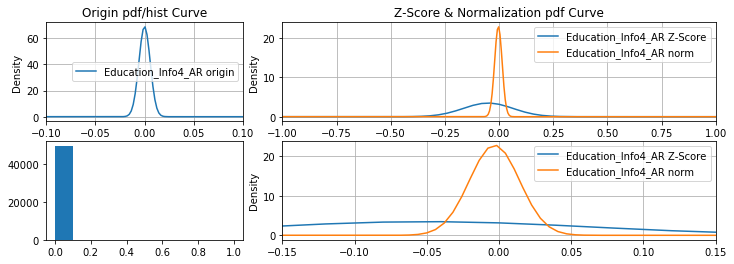

In [185]:
# icy
# dac.loc[:,[icy]]
# 正态标准化
# 正态标准化的特点：只保留排序关系，彻底去除有偏分布和极端值，在大样本情况下直接满足众多模型假设
x_test = x.iloc[:, :5]
x_test.head()
xx_test = x_test.iloc[:,0]
# xx_test.hist()
# xx_test.plot(kind='kde')
obj = xx_test
fig = plt.figure(figsize=(12,4))
# fig.set(alpha = 1)
plt.subplot2grid((2,3),(0,0))
obj.plot(kind='kde')
plt.xlim(-0.1, 0.1)
plt.legend(['{} origin'.format(obj.name)], loc='best')
plt.grid()
plt.title('Origin pdf/hist Curve')
obj_zscore = (obj - obj.mean())/obj.std()
obj_norm = (obj.rank(pct=True) - 0.5/obj.shape[0]).apply(st.norm.ppf)

plt.subplot2grid((2,3),(0,1),colspan=2)
obj_zscore.plot(kind='kde')
obj_norm.plot(kind='kde')
plt.xlim(-1, 1)
plt.legend(['{} Z-Score'.format(obj.name),'{} norm'.format(obj.name)], loc='best')
plt.grid()
plt.title('Z-Score & Normalization pdf Curve')

plt.subplot2grid((2,3),(1,0))
obj.hist()
plt.grid()

plt.subplot2grid((2,3),(1,1), colspan=2)
obj_zscore.plot(kind='kde')
obj_norm.plot(kind='kde')
plt.xlim(-0.15, 0.15)
plt.legend(['{} Z-Score'.format(obj.name),'{} norm'.format(obj.name)], loc='best')
plt.grid()
plt.show()
# fig.savefig("/Users/fanghan/Desktop/zscore_normalization_2.png")

In [192]:
# 0-1两点分布 - 正态标准化
# xx_test.describe()
tmp = pd.value_counts(xx_test)
print '0-1分布数据：'
print 'shape=', np.shape(xx_test)
print xx_test.head()
print '\nvalue_counts:'
print tmp
# rank : 
# Compute numerical data ranks (1 through n) along axis. 
# Equal values are assigned a rank that is the average of the ranks of those values 计数从1开始
print '\nrank():'
print xx_test.rank().drop_duplicates()
print '\nrank(pct=True):'
print xx_test.rank(pct=True).drop_duplicates()
print '\n debug for rank() & rank(pct=true):'
print 'rank() of 0:', np.mean(1.0 + np.arange(tmp[0]))
print 'rank() of 1:', np.mean(1.0 + tmp[0] + np.arange(tmp[1]))
print 'rank(pct=True) of 0:', np.mean(1.0 + np.arange(tmp[0]))/np.shape(xx_test)[0]
print 'rank(pct=True) of 1:', np.mean(1.0 + tmp[0] + np.arange(tmp[1]))/np.shape(xx_test)[0]
# 理解：pct=True参数相当于rank()/shape[0]
# 理解：xx_test.rank()的值域为[1,n]
print (xx_test.rank(pct=True)-0.5/np.shape(xx_test)[0]).drop_duplicates()

0-1分布数据：
shape= (49999,)
Idx
10001    0.0
10002    0.0
10003    0.0
10006    0.0
10007    0.0
Name: Education_Info4_AR, dtype: float64

value_counts:
0.0    49873
1.0      126
Name: Education_Info4_AR, dtype: int64

rank():
Idx
10001    24937.0
10829    49936.5
Name: Education_Info4_AR, dtype: float64

rank(pct=True):
Idx
10001    0.49875
10829    0.99875
Name: Education_Info4_AR, dtype: float64

 debug for rank() & rank(pct=true):
rank() of 0: 24937.0
rank() of 1: 49936.5
rank(pct=True) of 0: 0.498749974999
rank(pct=True) of 1: 0.998749975
Idx
10001    0.49874
10829    0.99874
Name: Education_Info4_AR, dtype: float64


In [101]:
# (xx_test.rank(pct=True)-0.5/xx_test.shape[0]).apply(st.norm.ppf)

In [72]:
# rank函数
# a = np.arange(10)
# a.rank() # AttributeError: 'numpy.ndarray' object has no attribute 'rank'
# pd.Series(a).rank()